In [1]:
import os
import sys
import dcor
import pandas as pd
from sklearn.model_selection import train_test_split

from dowhy import CausalModel
from dowhy.causal_estimator import CausalEstimate

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality # noqa F401
from auto_causality.data_utils import preprocess_dataset # noqa F401
from auto_causality.scoring import Scorer # noqa F401
from auto_causality.datasets import iv_dgp_econml # noqa F401

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Needed since ac.model.estimator doesn't include additional params -
# treatment, outcome etc. - needed from CausalEstimate instance
def energy_scorer_patch(
    estimate: CausalEstimate,
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: [],
):

    df["dy"] = estimate.estimator.effect(df[effect_modifiers])
    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score

In [3]:
TE = 10
data = iv_dgp_econml(true_effect=TE)

treatment = data.treatment
targets = data.outcomes
instruments = data.instruments
data_df, features_X, features_W = preprocess_dataset(
    data.data, treatment, targets, instruments
)

outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
1253,1.0,17.599277,1.0,0.644956,-1.222788,0.559939,1.009126,0.798294,1.127974,0.429798,1.568990,1.146353,-0.217534,0.0
4360,1.0,23.082254,1.0,-1.076135,-0.787102,0.438772,0.093021,-1.110272,-0.297603,-1.080770,-0.308543,1.828037,0.391535,0.0
4484,1.0,18.996712,1.0,-0.456429,-0.530051,1.271834,0.451466,-0.368840,0.215169,0.879576,0.860858,0.438808,1.005618,1.0
4615,0.0,9.359161,0.0,-0.447922,-1.621076,-0.179459,0.341797,1.424550,2.050861,0.295437,1.104863,0.177699,-0.212864,1.0
1707,1.0,21.251329,1.0,0.159731,-1.847981,-1.039317,0.569759,1.899550,-0.234906,0.158793,0.182551,0.824363,1.922035,0.0


In [4]:
ac = AutoCausality(
    time_budget=250,
    estimator_list=["OrthoIV", "DMLIV"],
    verbose=3,
    components_verbose=2,
    components_time_budget=10,
    propensity_model="auto",
)

ac.fit(train_df, treatment, outcome, features_W, features_X, instruments)

Component model time budget is 10. Recommended value is at least 300 for smallish datasets, 1800 for datasets with> 100K rows
[I 2022-07-22 09:27:57,480] A new study created in memory with name: optuna
[flaml.tune.tune: 07-22 09:27:57] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}




Components
{'task': 'regression', 'verbose': 2, 'pred_time_limit': 1e-05, 'n_jobs': -1, 'time_budget': 10}
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}]
Initial config =  [{'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[flaml.tune.tune: 07-22 09:28:49] {110} INFO - result: {'energy_distance': 0.03263839551711012, 'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'scores': {'train': {'energy_distance': 0.007269128509856948}, 'validation': {'energy_distance': 0.03263839551711012}}, 'config': {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, 'training_iteration': 0, 'config/estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}, 'experiment_tag': 'exp', 'time_total_s': 51.90871500968933}
[flaml.tune.tune: 07-22 09:28:49] {456} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[flaml.automl: 07-22 09:29:24] {2322} WARNING - Time taken to find the best model is 74% of the provided time budget and not all estimators' 

In [5]:
# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")

Best estimator: iv.econml.iv.dml.OrthoIV
best config: {'estimator': {'mc_agg': 'median', 'estimator_name': 'iv.econml.iv.dml.OrthoIV'}}
best score: 0.03224861060580331


In [7]:
 # Comparing best model searched to base IV model configuration
model = CausalModel(
    data=train_df,
    treatment=treatment,
    outcome=outcome[0],
    effect_modifiers=features_X,
    common_causes=["random"],
    instruments=instruments,
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.econml.iv.dml.DMLIV",
    method_params={
        "init_params": {},
        "fit_params": {},
    },
    test_significance=False,
)

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [8]:
Xtest = test_df[features_X]
print("True Effect  = ", TE)
print(
    "(Baseline Estimator) Treatment Effect: ",
    estimate.estimator.effect(Xtest).mean(),
)
print(
    "(AutoCausality Estimator) Treatment Effect: ",
    ac.model.estimator.estimator.effect(Xtest).mean(),
)
print()

True Effect  =  10
(Baseline Estimator) Treatment Effect:  10.413059081893945
(AutoCausality Estimator) Treatment Effect:  9.898166333225497



In [10]:
# Compute Energy distance for True & No Effect
def energy_scorer_patch_ne(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: [],
    true_effect = 10,
    ne = True
):

    df["dy"] = [0] * len(df) if ne else [true_effect] * len(df)
    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score


In [12]:
print("Energy distance scores")
base_estimator_edist = Scorer.energy_distance_score(estimate, test_df)
ac_estimator_edist = energy_scorer_patch(
    ac.model.estimator, test_df, treatment, outcome, instruments[0], features_X
)
ac_estimator_edist_ne = energy_scorer_patch_ne(
    test_df, treatment, outcome, instruments[0], features_X,
)
ac_estimator_edist_te = energy_scorer_patch_ne(
    test_df, treatment, outcome, instruments[0], features_X, true_effect=10, ne=False
)
print("\n(Baseline Estimator) Energy distance score: ", base_estimator_edist)
print("(AutoCausality Estimator) Energy distance score: ", ac_estimator_edist)
print("\n(No Effect) Energy distance score: ", ac_estimator_edist_ne)
print("(True Effect) Energy distance score: ", ac_estimator_edist_te)

Energy distance scores

(Baseline Estimator) Energy distance score:  0.05185463810942803
(AutoCausality Estimator) Energy distance score:  0.01900190141004998

(No Effect) Energy distance score:  4.285133271788457
(True Effect) Energy distance score:  0.02276366579787137


y iv.econml.iv.dml.OrthoIV


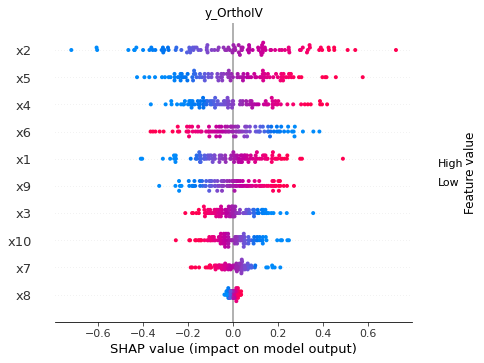

In [22]:
# Visualize Feature importance
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()
